In [30]:
#2D isothermal cylindrical SS and just SMR
'''
FOCUS ON 1D ENERGY BALANCE FOR NOW

SOME THINGS TO INVESTIGATE:
- velocity profile: do the overall conversion at each axial point (integrate at each length the overall conversion)
- BOUNDARY CONCENTRATIONS ARE LOWER THAN EXPECTED WHEN CONVERTING TO 1D
- CO2 CONC HIGHER THAN EXPECTED
- DIFFUSION
'''
from scipy.integrate import solve_bvp, solve_ivp, odeint
import numpy as np
import matplotlib.pyplot as plt

In [31]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m
R = R_outer - R_inner

T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec
print(v0)

D1 = D2 = D3 = D4 = D5 = D6 = 8*10**-7
D = [D1, D2, D3, D4, D5, D6] #list of diffusion coefficient

Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

num_z, num_x = 50, 20 # Dimensions of the 2D domain
nz, nx = num_z, num_x+2   # Number of spatial grid points with 2 imaginary nodes
dz, dx = L / (nz - 1), R / (nx - 1)  # Spatial step sizes
z = np.linspace(0, L, nz)
x = np.linspace(0, R, nx)

u_init = np.zeros((6, len(x), len(z))).flatten() #THE NUMBER OF COMPONENTS

v = np.zeros((len(x)-2, len(z)))

def pde(t,y):
    y = y.reshape((6, nx, nz)) #THE NUMBER OF COMPONENTS
    dydx2 = np.zeros_like(y)
    dydz = np.zeros_like(y)
    dydt = np.zeros_like(y)

    #MAYBE I NEED TO RESET THE BOUNDARY CONDITIONS IN HERE
    for i in range(len(D)):
        y[i,:,0] = y0[i] #i, x, z

    #no flux boundary condition 
    y[:,0,1:] = y[:,2,1:] #makes it so that there is no flux on top boundary (imaginary point in y)
    
    ych4 = y[0,-2,1:]
    yh2o = y[1,-2,1:]
    yco = y[2,-2,1:]
    yco2 = y[3,-2,1:]
    yh2 = y[4,-2,1:]

    ych4avg = np.sum(y[0, 1:-1, :]/(nx-2), axis = 0)

    v[:] = v0*(-2*ych4avg + 3*y0[0])/y0[0]

    rsmr = Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(ych4*yh2o-(P**2)*yco*(yh2**3)/Keqsmr)
    rwgs = Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(yh2o*yco-yco2*yh2/Keqwgs)
   
    #reaction boundary conditions.
    y[0,-1,1:] = y[0,-3,1:] + 2*dx/D1 * (- rsmr)
    y[1,-1,1:] = y[1,-3,1:] + 2*dx/D2 * (- rsmr - rwgs)
    y[2,-1,1:] = y[2,-3,1:] + 2*dx/D3 * (rsmr - rwgs)
    y[3,-1,1:] = y[3,-3,1:] + 2*dx/D4 * (rwgs)
    y[4,-1,1:] = y[4,-3,1:] + 2*dx/D5 * (3*rsmr + rwgs)
    y[5,-1,1:] = y[5,-3,1:]

    dydz[:,1:-1,1:] = (y[:,1:-1,1:] - y[:,1:-1,:-1])/dz
    dydx2[:,1:-1,:] = (y[:,2:, :] - 2 * y[:,1:-1, :] + y[:,:-2, :]) / dx**2

    for i in range(len(D)):
        dydt[i, 1:-1, :] = D[i] * dydx2[i, 1:-1, :] - v * dydz[i, 1:-1, :]

    return dydt.flatten()


t_final = 10
t_span = (0, t_final)  # Time interval
t_eval = np.linspace(0, t_final, 10)  # Time evaluation points

sol = solve_ivp(pde, t_span, u_init, method='RK45', t_eval=t_eval)

sol_plot = sol.y[:, -1].reshape((6, nx, nz)) #6 is number of components
# print(sol_plot[5,1:-1,:])

[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]
0.019712035219026


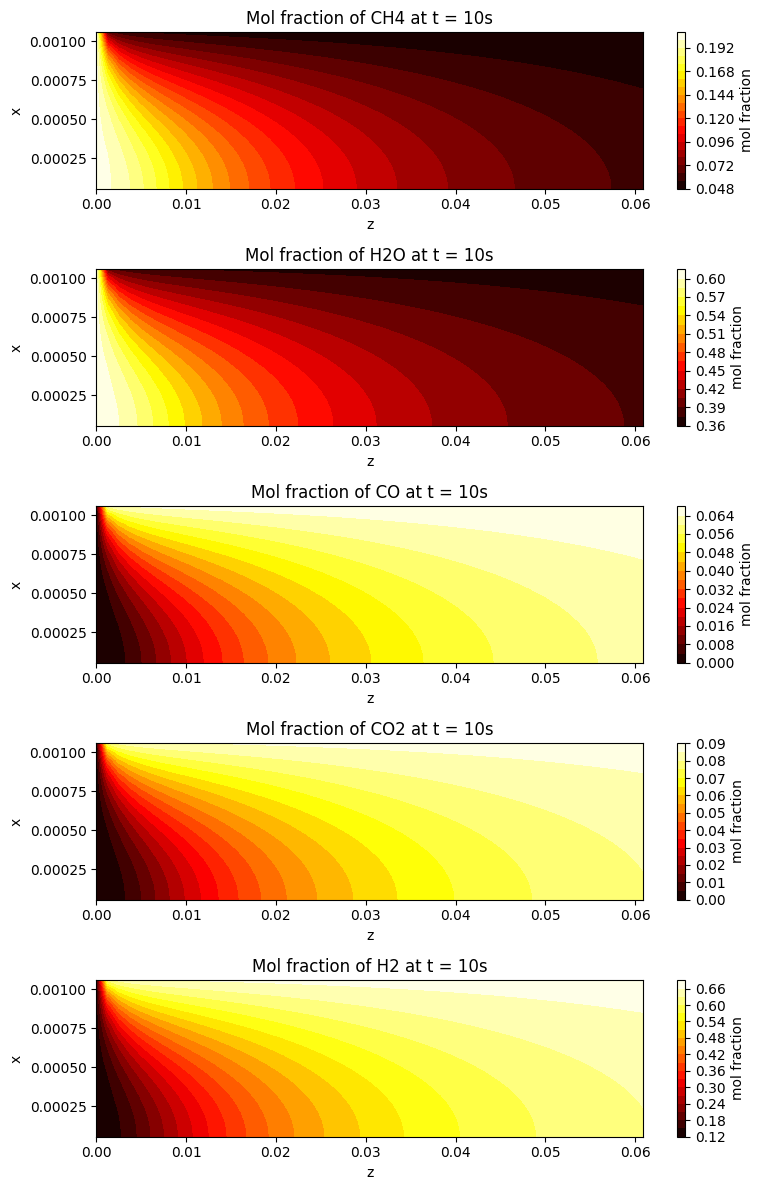

In [32]:
num_plts = 5
fig, ax = plt.subplots(num_plts, 1, figsize=(8, 12))
levels = np.linspace(0,1,100)
labels = ['CH4', 'H2O', 'CO', 'CO2', 'H2', 'Ar']
for i in range(num_plts):
    ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot')
    ax[i].set_title(f'Mol fraction of {labels[i]} at t = {sol.t[-1]:.0f}s')
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('x')
    fig.colorbar(ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot'), ax=ax[i], label='mol fraction')

plt.tight_layout()
plt.show()

[[0.20291311 0.17390423 0.16041743 0.15069148 0.14282578 0.13612454
  0.13024733 0.12499896 0.12025508 0.11593028 0.1119624  0.10830418
  0.10491838 0.10177483 0.09884856 0.09611847 0.09356653 0.09117711
  0.08893655 0.08683279 0.08485512 0.08299399 0.0812408  0.07958782
  0.07802803 0.07655505 0.07516309 0.07384682 0.07260139 0.0714223
  0.07030546 0.06924704 0.06824354 0.0672917  0.0663885  0.06553112
  0.06471696 0.06394359 0.06320871 0.06251023 0.06184614 0.06121459
  0.06061383 0.06004224 0.05949827 0.05898048 0.05848752 0.0580181
  0.05757785 0.05713861]
 [0.60873933 0.56360523 0.5424624  0.52722039 0.51489511 0.50439487
  0.49518573 0.48696159 0.47952755 0.47274974 0.46653079 0.46079667
  0.45548906 0.45056076 0.44597263 0.4416917  0.43768972 0.43394226
  0.43042792 0.42712783 0.42402526 0.42110524 0.41835432 0.4157604
  0.41331249 0.41100063 0.40881572 0.40674945 0.4047942  0.40294295
  0.40118928 0.39952721 0.39795124 0.39645628 0.39503759 0.39369078
  0.39241174 0.39119667 0.

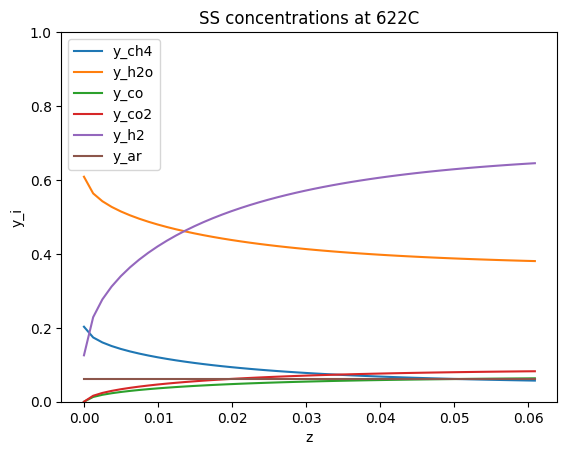

In [33]:
sol_1d = np.sum(sol_plot[:, 1:-1, :]/(nx-2), axis = 1)
print(sol_1d)
plt.plot(z, sol_1d[0], label='y_ch4')
plt.plot(z, sol_1d[1], label='y_h2o')
plt.plot(z, sol_1d[2], label='y_co')
plt.plot(z, sol_1d[3], label='y_co2')
plt.plot(z, sol_1d[4], label='y_h2')
plt.plot(z, sol_1d[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS concentrations at ' + str(T-273) + 'C')
plt.legend()

In [34]:
print(sol_1d[:,-1])
print(sum(sol_1d[:,-1]))

[0.05713861 0.3805329  0.06334256 0.08243193 0.64532047 0.06278252]
1.291548994405735


Text(0.5, 1.0, 'Velocty profile')

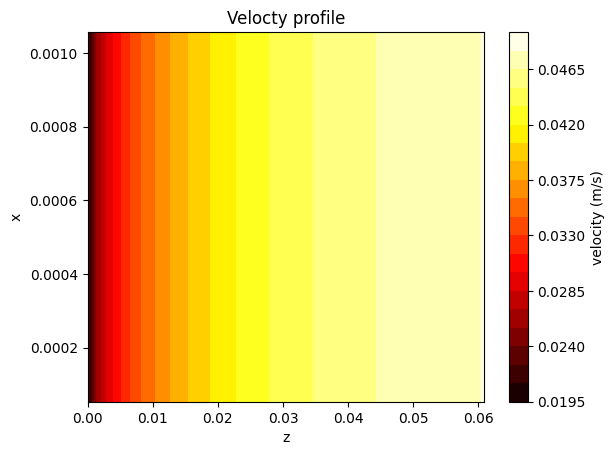

In [35]:
# print(v)
contour = plt.contourf(z, x[1:-1], v, 20, cmap='hot')
plt.colorbar(contour, label='velocity (m/s)')
plt.xlabel('z')
plt.ylabel('x')
plt.title('Velocty profile')
